In [1]:
import torch
from transformers import EsmModel, AutoTokenizer

/storage/praha1/home/nexuso1/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model, tokenizer = EsmModel.from_pretrained('facebook/esm2_t33_650M_UR50D'), AutoTokenizer.from_pretrained('facebook/esm2_t33_650M_UR50D')

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
import pandas as pd

In [4]:
kinases = pd.read_csv('../data/kinases.csv')

In [5]:
kinases

,uniprot_id,sequence
0,O43318,MSTASAASSSSSSSAGEMIEAPSQVLNFEEIDYKEIEVEEVVGRGA...
1,P16234,MGTSHPAFLVLGCLLTGLSLILCQLSLPSILPNENEKVVQLNSSFS...
2,O75460,MPARRLLLLLTLLLPGLGIFGSTSTVTLPETLLFVSTLDGSLHAVS...
3,Q6IQ55,MSGGGEQLDILSVGILVKERWKVLRKIGGGGFGEIYDALDMLTREN...
4,Q14164,MQSTANYLWHTDDLLGQGATASVYKARNKKSGELVAVKVFNTTSYL...
...,...,...
69,Q96RR4,MSSCVSSQPSSNRAAPQDELGGRGSSSSESQKPCEALRGLSSLSIH...
70,Q04912,MELLPPLPQSFLLLLLLPAKPAAGEDWQCPRTPYAASRDFDVKYVV...
71,Q96S44,MAAARATTPADGEEPAPEAEALAAARERSSRFLSGLELVKQGAEAR...
72,Q9Y572,MSCVKLWPSGAPAPLVSIEELENQELVGKGGFGTVFRAQHRKWGYD...


In [6]:
residues = ['S', 'T', 'Y']

In [7]:
res_dfs = []
for r in residues:
    res_dfs.append(pd.read_csv(f'../data/kinases_{r}.csv'))

In [8]:
res_dfs[0]

,kinase_top1_id,kinase_top5_id,kinase_top10_id
0,O00311,Q5TCY1,Q5TCY1
1,Q5TCY1,Q96Q15,Q96Q15
2,Q8IXL6,O00311,P51617
3,Q96Q15,P51617,O00311
4,Q9BXM7,Q8IXL6,Q16654
5,P51617,Q16654,O75385
6,Q9BX84,Q96S44,Q15118
7,Q16654,Q15118,O75460
8,Q8TAS1,Q9BX84,Q8IXL6
9,Q96S44,O75385,Q96S44


In [9]:
kinases = kinases.set_index('uniprot_id')

In [10]:
kinases

,sequence
uniprot_id,
O43318,MSTASAASSSSSSSAGEMIEAPSQVLNFEEIDYKEIEVEEVVGRGA...
P16234,MGTSHPAFLVLGCLLTGLSLILCQLSLPSILPNENEKVVQLNSSFS...
O75460,MPARRLLLLLTLLLPGLGIFGSTSTVTLPETLLFVSTLDGSLHAVS...
Q6IQ55,MSGGGEQLDILSVGILVKERWKVLRKIGGGGFGEIYDALDMLTREN...
Q14164,MQSTANYLWHTDDLLGQGATASVYKARNKKSGELVAVKVFNTTSYL...
...,...
Q96RR4,MSSCVSSQPSSNRAAPQDELGGRGSSSSESQKPCEALRGLSSLSIH...
Q04912,MELLPPLPQSFLLLLLLPAKPAAGEDWQCPRTPYAASRDFDVKYVV...
Q96S44,MAAARATTPADGEEPAPEAEALAAARERSSRFLSGLELVKQGAEAR...


In [13]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('gpu')
model.to(device)

EsmModel(
  (embeddings): EsmEmbeddings(
    (word_embeddings): Embedding(33, 1280, padding_idx=1)
    (dropout): Dropout(p=0.0, inplace=False)
    (position_embeddings): Embedding(1026, 1280, padding_idx=1)
  )
  (encoder): EsmEncoder(
    (layer): ModuleList(
      (0-32): 33 x EsmLayer(
        (attention): EsmAttention(
          (self): EsmSelfAttention(
            (query): Linear(in_features=1280, out_features=1280, bias=True)
            (key): Linear(in_features=1280, out_features=1280, bias=True)
            (value): Linear(in_features=1280, out_features=1280, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (rotary_embeddings): RotaryEmbedding()
          )
          (output): EsmSelfOutput(
            (dense): Linear(in_features=1280, out_features=1280, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (LayerNorm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        )
        (intermediate): EsmInter

In [14]:
embs = {}
with torch.no_grad():
    for index, row in kinases.iterrows():
        max_len = 1022
        print(index, end='')
        if len(row.sequence) > max_len:
            n = len(row.sequence) // max_len
            chunks = []
            for i in range(n):
                chunk = row.sequence[i*max_len:(i+1)*max_len]
                inputs = tokenizer(chunk, return_tensors='pt', ).to(device)
                out = model(**inputs)[0].squeeze()
                chunks.append(out[1:-1])
            chunk = row.sequence[n*max_len:]
            inputs = tokenizer(chunk, return_tensors='pt').to(device)
            out = model(**inputs)[0].squeeze()
            chunks.append(out[1:-1])

            emb = torch.cat(chunks, axis=0)
        else:
            inputs = tokenizer(row.sequence, return_tensors='pt').to(device)
            emb =  model(**inputs)[0].squeeze()[1:-1]
        print(' ...done')
        embs[index] = emb

O43318 ...done
P16234 ...done
O75460 ...done
Q6IQ55 ...done
Q14164 ...done
P00540 ...done
Q15831 ...done
Q13882 ...done
Q99683 ...done
P36507 ...done
O15111 ...done
O75385 ...done
P49674 ...done
Q9BXM7 ...done
Q16654 ...done
Q06187 ...done
Q08345 ...done
P07949 ...done
Q9UF33 ...done
O15146 ...done
P51617 ...done
Q5TCY1 ...done
Q13470 ...done
P00519 ...done
Q8N5S9 ...done
Q05397 ...done
P35968 ...done
Q8IXL6 ...done
Q9NSY1 ...done
Q02763 ...done
P52333 ...done
P33981 ...done
O60674 ...done
Q13555 ...done
Q8IYT8 ...done
Q13164 ...done
P19784 ...done
Q2M2I8 ...done
P09769 ...done
Q9UEW8 ...done
P48730 ...done
Q6ZN16 ...done
Q8TAS1 ...done
P68400 ...done
P36888 ...done
Q02750 ...done
O00311 ...done
Q5S007 ...done
Q07912 ...done
Q96KB5 ...done
P29597 ...done
O95382 ...done
P09619 ...done
P57058 ...done
Q96GX5 ...done
Q86Y07 ...done
O14976 ...done
Q76MJ5 ...done
P35916 ...done
Q99986 ...done
Q15118 ...done
Q16832 ...done
P17948 ...done
Q96Q15 ...done
Q96PY6 ...done
P23458 ...done
O43683 ...

In [15]:
mean_embs = {k : v.mean(0) for k, v in embs.items()}

In [16]:
mean_embs

{'O43318': tensor([ 0.0221, -0.0159,  0.0221,  ..., -0.1512,  0.1184,  0.1023],
        device='cuda:0'),
 'P16234': tensor([ 0.0136, -0.0553, -0.0245,  ..., -0.0819,  0.0014,  0.0573],
        device='cuda:0'),
 'O75460': tensor([ 0.0183, -0.0146, -0.0480,  ..., -0.1101,  0.0507,  0.1025],
        device='cuda:0'),
 'Q6IQ55': tensor([ 0.0110, -0.0846,  0.0209,  ..., -0.0508,  0.0460,  0.0344],
        device='cuda:0'),
 'Q14164': tensor([-9.7546e-05, -5.3207e-02,  1.3376e-02,  ..., -9.8739e-02,
          1.1476e-01,  8.8691e-02], device='cuda:0'),
 'P00540': tensor([ 0.0177, -0.0621,  0.0167,  ..., -0.0778,  0.0788,  0.0301],
        device='cuda:0'),
 'Q15831': tensor([-0.0125, -0.0752, -0.0530,  ..., -0.1976,  0.0670,  0.1301],
        device='cuda:0'),
 'Q13882': tensor([ 0.0208, -0.0144, -0.0411,  ..., -0.1132,  0.0615,  0.0874],
        device='cuda:0'),
 'Q99683': tensor([ 0.0028, -0.0662, -0.0384,  ..., -0.1111,  0.0242,  0.1221],
        device='cuda:0'),
 'P36507': tensor([-0

In [ ]:
torch.save(embs, 'bio-research/data/kinase_embeddings.pt')

In [19]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [20]:
pca = PCA(n_components=3, svd_solver='full')

In [21]:
for k, v in mean_embs.items():
    mean_embs[k] = v.to('cpu').numpy()

In [22]:
pca.fit(list(mean_embs.values()))

PCA(n_components=3, svd_solver='full')

In [23]:
pca.explained_variance_ratio_

array([0.5240231 , 0.1133913 , 0.07621829])

In [24]:
transformed = pca.transform(list(mean_embs.values()))

In [25]:
import matplotlib.pyplot as plt

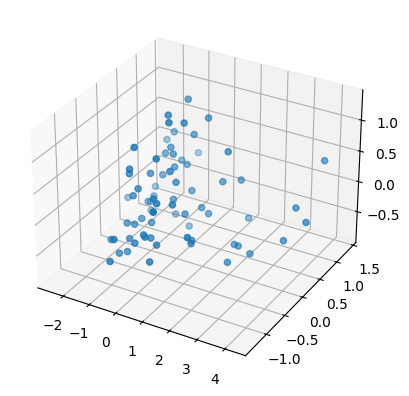

In [26]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(transformed[:, 0], transformed[:, 1], transformed[:, 2])

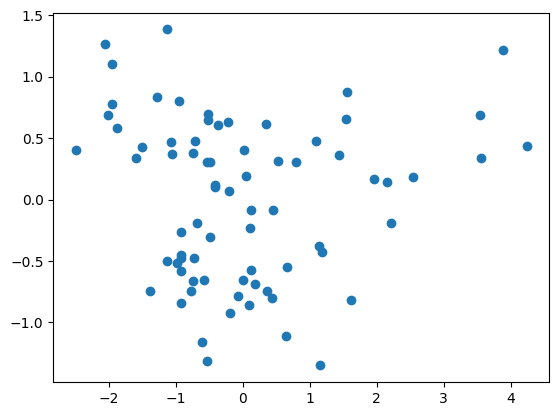

In [27]:
plt.scatter(transformed[:, 0], transformed[:, 1])

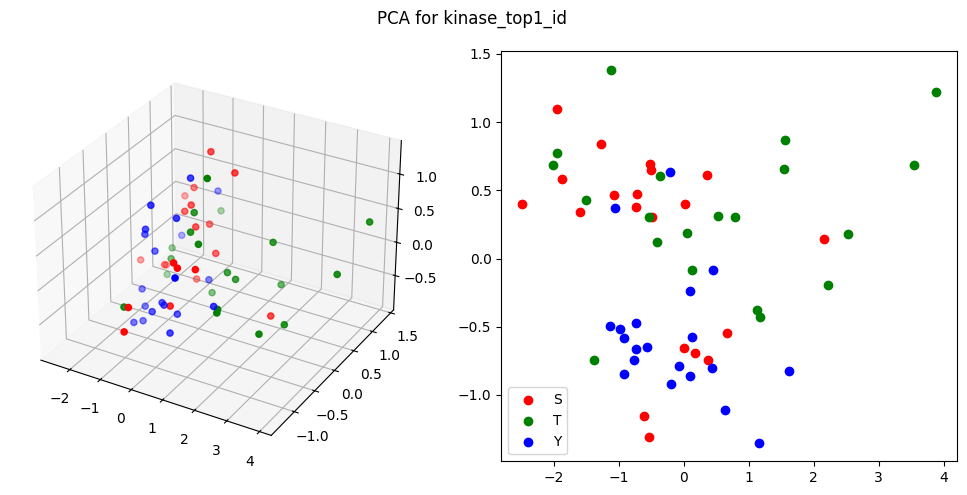

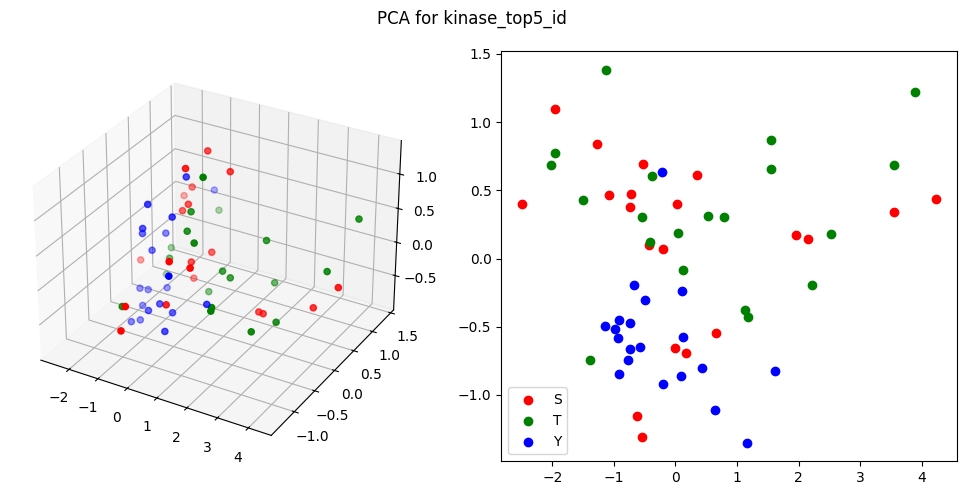

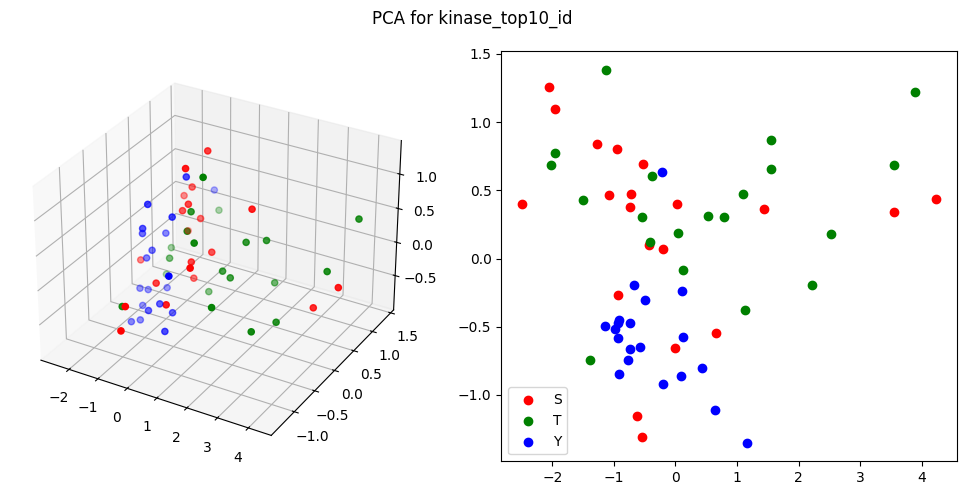

In [39]:
import numpy as np

cols = res_dfs[0].columns
colors = ['r', 'g', 'b']
for col in cols:
    fig = plt.figure(figsize=(10, 5))
    ax3d = fig.add_subplot(121, projection='3d')
    ax2d = fig.add_subplot(122)
    for i, df in enumerate(res_dfs):
        ids = df[col]
        res_embs = []
        for id in ids:
            res_embs.append(mean_embs[id])
            
        res_embs = np.asarray(res_embs)
        transformed = pca.transform(res_embs)
        ax3d.scatter(transformed[:, 0], transformed[:, 1], transformed[:, 2], color=colors[i], label=residues[i])
        ax2d.scatter(transformed[:, 0], transformed[:, 1], color=colors[i], label=residues[i])
    fig.suptitle(f'PCA for {col}')
    plt.legend()
    plt.tight_layout()
    plt.show()
        

In [37]:
tsne = TSNE(n_components=3, random_state=42)

In [40]:
id_to_res = {}
for i, df in enumerate(res_dfs):
        ids = df[col]
        for id in ids:
            id_to_res[id] = residues[i]

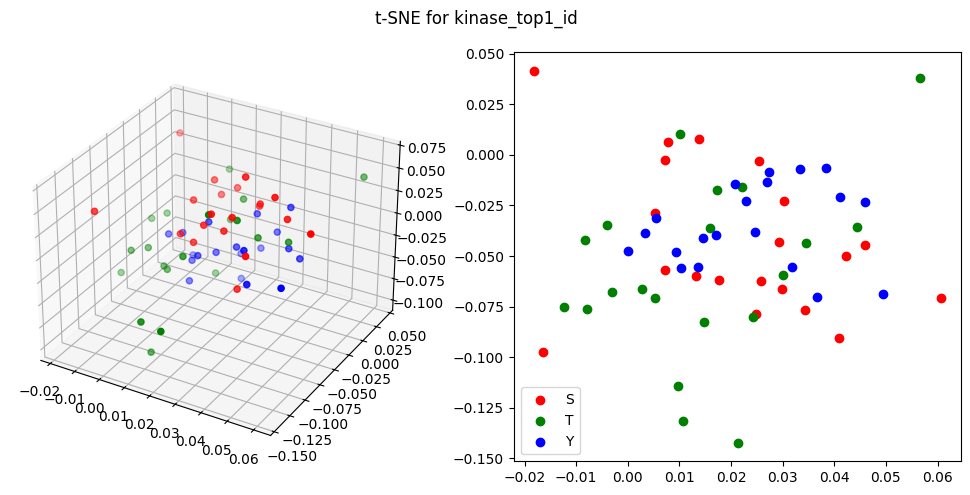

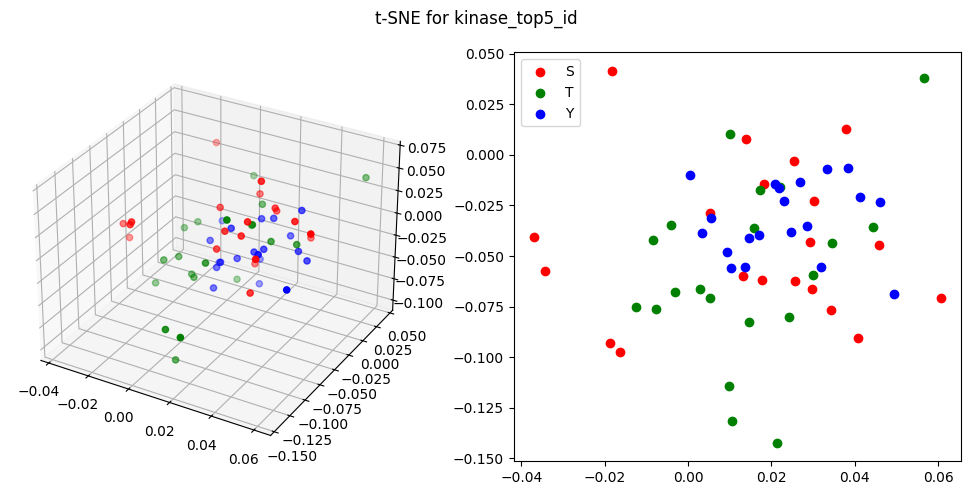

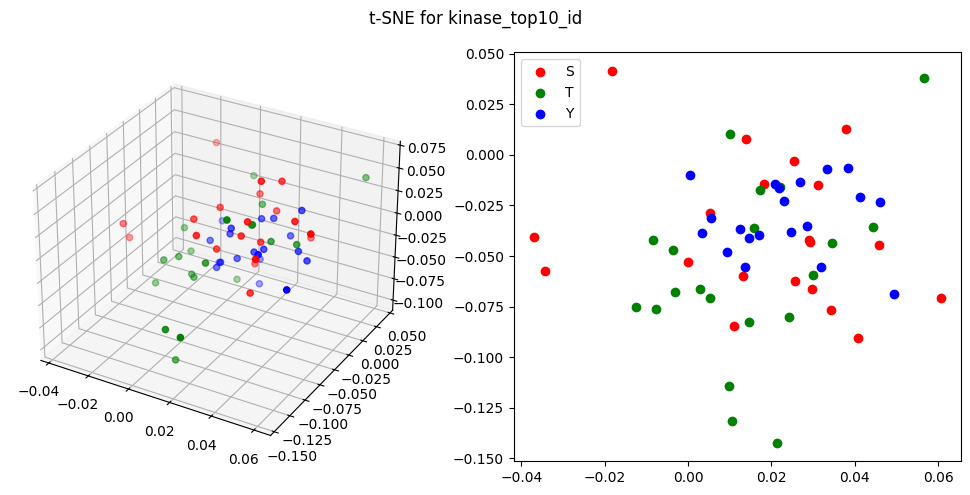

In [38]:
transformed=tsne.fit_transform(np.asarray(list(mean_embs.values())))

cols = res_dfs[0].columns
colors = ['r', 'g', 'b']
for col in cols:
    for i, df in enumerate(res_dfs):
        ids = df[col]
        
    fig = plt.figure(figsize=(10, 5))
    ax3d = fig.add_subplot(121, projection='3d')
    ax2d = fig.add_subplot(122)
    ax3d.scatter(transformed[:, 0], transformed[:, 1], transformed[:, 2], color=colors[i], label=residues[i])
    ax2d.scatter(transformed[:, 0], transformed[:, 1], color=colors[i], label=residues[i])
    fig.suptitle(f't-SNE for {col}')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [101]:
cols = res_dfs[0].columns[1:]
for df in res_dfs:
    ids = set(df[cols[0]])
    for col in cols[1:]:
        ids = ids & set(df[col].to_list())
    print(len(ids))
    print(df.shape)
    

16
(20, 3)
19
(20, 3)
19
(20, 3)


In [102]:
res_dfs[0]

,kinase_top1_id,kinase_top5_id,kinase_top10_id
0,O00311,Q5TCY1,Q5TCY1
1,Q5TCY1,Q96Q15,Q96Q15
2,Q8IXL6,O00311,P51617
3,Q96Q15,P51617,O00311
4,Q9BXM7,Q8IXL6,Q16654
5,P51617,Q16654,O75385
6,Q9BX84,Q96S44,Q15118
7,Q16654,Q15118,O75460
8,Q8TAS1,Q9BX84,Q8IXL6
9,Q96S44,O75385,Q96S44


There is quite an overlap between the top rankings, as expected

In [15]:
def generate_embeddings(kinases, model, tokenizer):
    embs = {}
    with torch.no_grad():
        for index, row in kinases.iterrows():
            max_len = 1022
            print(index, end='')
            if len(row.sequence) > max_len:
                n = len(row.sequence) // max_len
                chunks = []
                for i in range(n):
                    chunk = row.sequence[i*max_len:(i+1)*max_len]
                    inputs = tokenizer(chunk, return_tensors='pt', ).to(device)
                    out = model(**inputs)[0].squeeze()
                    chunks.append(out[1:-1])
                chunk = row.sequence[n*max_len:]
                inputs = tokenizer(chunk, return_tensors='pt').to(device)
                out = model(**inputs)[0].squeeze()
                chunks.append(out[1:-1])

                emb = torch.cat(chunks, axis=0)
            else:
                inputs = tokenizer(row.sequence, return_tensors='pt').to(device)
                emb =  model(**inputs)[0].squeeze()[1:-1]
            print(' ...done')
            embs[index] = emb
            
    return embs

In [21]:
model, tokenizer = EsmModel.from_pretrained('facebook/esm2_t12_35M_UR50D'), AutoTokenizer.from_pretrained('facebook/esm2_t33_650M_UR50D')
model.to(device)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EsmModel(
  (embeddings): EsmEmbeddings(
    (word_embeddings): Embedding(33, 480, padding_idx=1)
    (dropout): Dropout(p=0.0, inplace=False)
    (position_embeddings): Embedding(1026, 480, padding_idx=1)
  )
  (encoder): EsmEncoder(
    (layer): ModuleList(
      (0-11): 12 x EsmLayer(
        (attention): EsmAttention(
          (self): EsmSelfAttention(
            (query): Linear(in_features=480, out_features=480, bias=True)
            (key): Linear(in_features=480, out_features=480, bias=True)
            (value): Linear(in_features=480, out_features=480, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (rotary_embeddings): RotaryEmbedding()
          )
          (output): EsmSelfOutput(
            (dense): Linear(in_features=480, out_features=480, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (LayerNorm): LayerNorm((480,), eps=1e-05, elementwise_affine=True)
        )
        (intermediate): EsmIntermediate(
  

In [22]:
embs_35 = generate_embeddings(kinases, model, tokenizer)

O43318 ...done
P16234 ...done
O75460 ...done
Q6IQ55 ...done
Q14164 ...done
P00540 ...done
Q15831 ...done
Q13882 ...done
Q99683 ...done
P36507 ...done
O15111 ...done
O75385 ...done
P49674 ...done
Q9BXM7 ...done
Q16654 ...done
Q06187 ...done
Q08345 ...done
P07949 ...done
Q9UF33 ...done
O15146 ...done
P51617 ...done
Q5TCY1 ...done
Q13470 ...done
P00519 ...done
Q8N5S9 ...done
Q05397 ...done
P35968 ...done
Q8IXL6 ...done
Q9NSY1 ...done
Q02763 ...done
P52333 ...done
P33981 ...done
O60674 ...done
Q13555 ...done
Q8IYT8 ...done
Q13164 ...done
P19784 ...done
Q2M2I8 ...done
P09769 ...done
Q9UEW8 ...done
P48730 ...done
Q6ZN16 ...done
Q8TAS1 ...done
P68400 ...done
P36888 ...done
Q02750 ...done
O00311 ...done
Q5S007 ...done
Q07912 ...done
Q96KB5 ...done
P29597 ...done
O95382 ...done
P09619 ...done
P57058 ...done
Q96GX5 ...done
Q86Y07 ...done
O14976 ...done
Q76MJ5 ...done
P35916 ...done
Q99986 ...done
Q15118 ...done
Q16832 ...done
P17948 ...done
Q96Q15 ...done
Q96PY6 ...done
P23458 ...done
O43683 ...

In [26]:
torch.save(embs_35, '../data/kinase_embeddings_35M.pt')